# Exercise 2 Solution: Comparing Intervention Strategies

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ngozzi/tech-transfer-epdemix/blob/main/sessions/session-4/solutions/python/exercise_2_interventions.ipynb)

Design and compare three different intervention strategies for controlling an outbreak.

In [1]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r",
                    "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

## Setup: Create Base SEIR Model

In [19]:
from epydemix import EpiModel
from epydemix.population import load_epydemix_population
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Dark2")

# Load US population
population = load_epydemix_population("United_States")

def create_seir_model():
    """Create a fresh SEIR model for the US."""
    model = EpiModel(name="SEIR", compartments=["S", "E", "I", "R"])
    
    model.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")
    model.add_transition(source="E", target="I", params="sigma", kind="spontaneous")
    model.add_transition(source="I", target="R", params="gamma", kind="spontaneous")
    
    model.add_parameter("beta", 0.035)
    model.add_parameter("sigma", 0.2)
    model.add_parameter("gamma", 0.1)
    
    model.set_population(population)
    return model

## Task 1 & 2: Implement Intervention Scenarios

In [20]:
# Create four models: baseline + three interventions
model_baseline = create_seir_model()
model_school = create_seir_model()
model_work = create_seir_model()
model_combined = create_seir_model()

# Scenario 1: School closure only (80% reduction, Apr 1 - Jun 30)
model_school.add_intervention(
    layer_name="school",
    start_date="2026-04-01",
    end_date="2026-06-30",
    reduction_factor=0.2,  # 80% reduction
    name="school closure"
)

# Scenario 2: Work-from-home only (60% reduction, Apr 1 - Aug 31)
model_work.add_intervention(
    layer_name="work",
    start_date="2026-04-01",
    end_date="2026-08-31",
    reduction_factor=0.4,  # 60% reduction
    name="work from home"
)

# Scenario 3: Combined but lighter (40% reduction in both, Apr 1 - May 31)
model_combined.add_intervention(
    layer_name="school",
    start_date="2026-04-01",
    end_date="2026-05-31",
    reduction_factor=0.6,  # 40% reduction
    name="partial school closure"
)
model_combined.add_intervention(
    layer_name="work",
    start_date="2026-04-01",
    end_date="2026-05-31",
    reduction_factor=0.6,  # 40% reduction
    name="partial work from home"
)

In [21]:
# Simulation parameters
sim_params = dict(
    start_date="2026-03-01",
    end_date="2026-12-31",
    Nsim=50,
    percentage_in_agents=10 / population.Nk.sum()
)

# Run all scenarios
print("Running baseline...")
results_baseline = model_baseline.run_simulations(**sim_params)

print("Running school closure...")
results_school = model_school.run_simulations(**sim_params)

print("Running work-from-home...")
results_work = model_work.run_simulations(**sim_params)

print("Running combined...")
results_combined = model_combined.run_simulations(**sim_params)

print("Done!")

Running baseline...
Running school closure...
Running work-from-home...
Running combined...
Done!


## Task 3: Compare Metrics

In [22]:
def compute_metrics(results):
    """Compute key metrics from simulation results."""
    trajectories = results.get_stacked_compartments()
    
    # Peak infection size
    peak_infections = trajectories["I_total"].max(axis=1)
    
    # Total infections (final R count)
    total_infections = trajectories["R_total"][:, -1]
    
    # Time to peak (in days from simulation start)
    time_to_peak = trajectories["I_total"].argmax(axis=1)
    
    return {
        "peak": peak_infections,
        "total": total_infections,
        "time_to_peak": time_to_peak
    }

# Compute metrics for all scenarios
metrics = {
    "Baseline": compute_metrics(results_baseline),
    "School Closure": compute_metrics(results_school),
    "Work-from-Home": compute_metrics(results_work),
    "Combined (lighter)": compute_metrics(results_combined)
}

In [23]:
import pandas as pd

# Create summary table
summary_data = []
baseline_total = np.median(metrics["Baseline"]["total"])
baseline_peak = np.median(metrics["Baseline"]["peak"])

for name, m in metrics.items():
    total_med = np.median(m["total"])
    peak_med = np.median(m["peak"])
    time_med = np.median(m["time_to_peak"])
    
    # Calculate reductions compared to baseline
    total_reduction = (baseline_total - total_med) / baseline_total * 100
    peak_reduction = (baseline_peak - peak_med) / baseline_peak * 100
    
    summary_data.append({
        "Scenario": name,
        "Peak Infections (M)": f"{peak_med/1e6:.1f}",
        "Peak Reduction (%)": f"{peak_reduction:.1f}" if name != "Baseline" else "-",
        "Total Infections (M)": f"{total_med/1e6:.1f}",
        "Total Reduction (%)": f"{total_reduction:.1f}" if name != "Baseline" else "-",
        "Time to Peak (days)": f"{time_med:.0f}"
    })

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

          Scenario Peak Infections (M) Peak Reduction (%) Total Infections (M) Total Reduction (%) Time to Peak (days)
          Baseline                93.9                  -                329.3                   -                 126
    School Closure                93.1                0.9                329.2                 0.0                 149
    Work-from-Home                83.0               11.7                323.9                 1.6                 134
Combined (lighter)                93.9                0.0                329.3                 0.0                 140


## Task 4: Summary Visualization

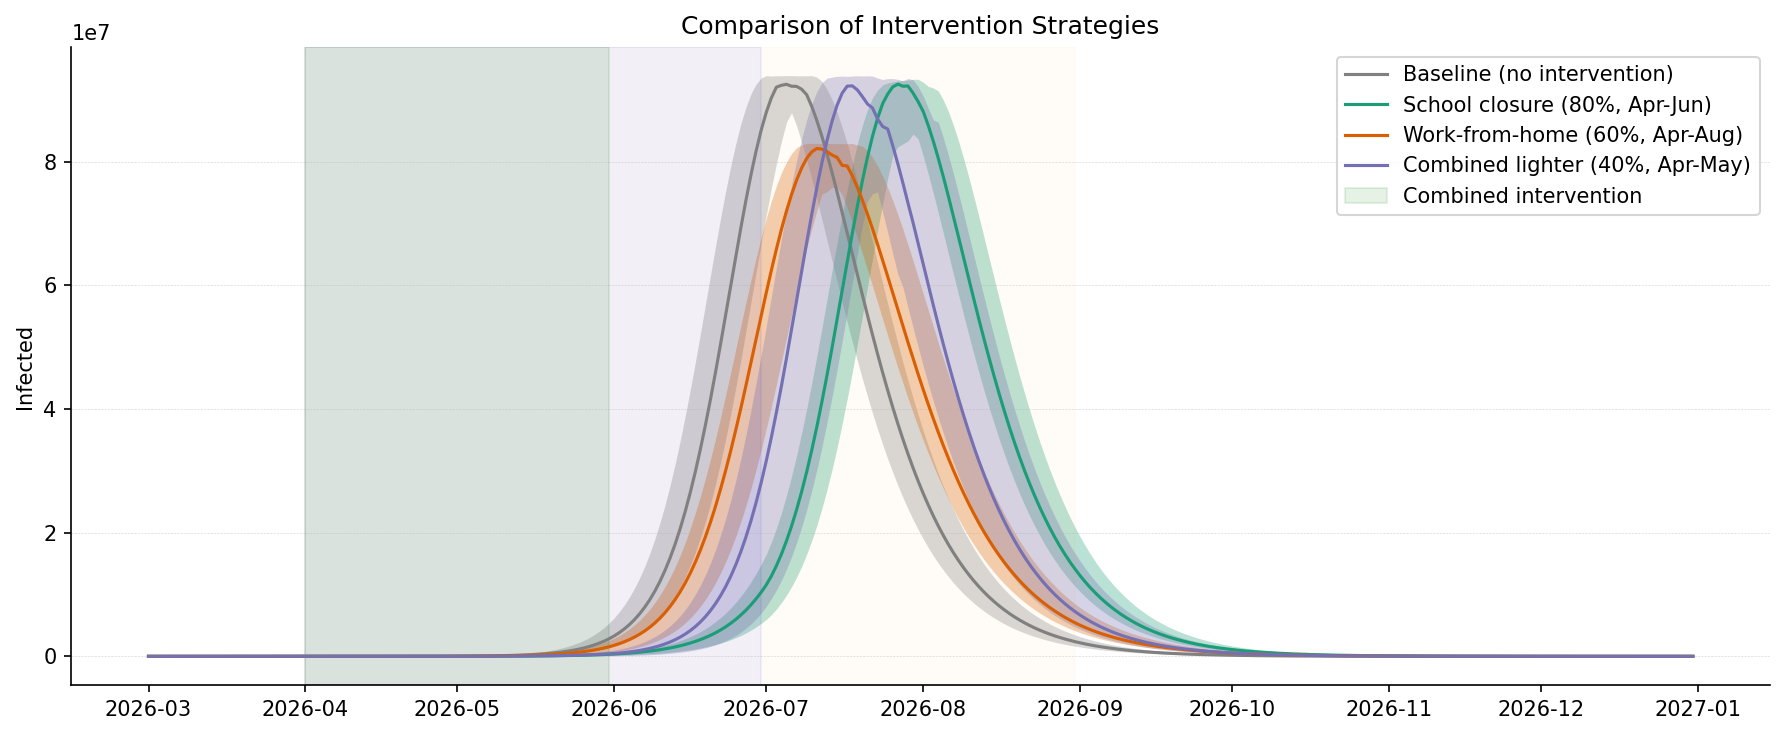

In [24]:
from epydemix.visualization import plot_quantiles

# Get quantiles for each scenario
df_baseline = results_baseline.get_quantiles_compartments()
df_school = results_school.get_quantiles_compartments()
df_work = results_work.get_quantiles_compartments()
df_combined = results_combined.get_quantiles_compartments()

# Plot infection curves
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

plot_quantiles(df_baseline, columns=["I_total"], ax=ax,
               colors="gray", labels=["Baseline (no intervention)"])
plot_quantiles(df_school, columns=["I_total"], ax=ax,
               colors=colors[0], labels=["School closure (80%, Apr-Jun)"])
plot_quantiles(df_work, columns=["I_total"], ax=ax,
               colors=colors[1], labels=["Work-from-home (60%, Apr-Aug)"])
plot_quantiles(df_combined, columns=["I_total"], ax=ax,
               colors=colors[2], labels=["Combined lighter (40%, Apr-May)"])

# Add intervention period markers
ax.axvspan("2026-04-01", "2026-05-31", alpha=0.1, color="green", label="Combined intervention")
ax.axvspan("2026-04-01", "2026-06-30", alpha=0.05, color="blue")
ax.axvspan("2026-04-01", "2026-08-31", alpha=0.03, color="orange")

ax.set_title("Comparison of Intervention Strategies")
ax.set_ylabel("Infected")
ax.legend(loc="upper right")

plt.tight_layout()

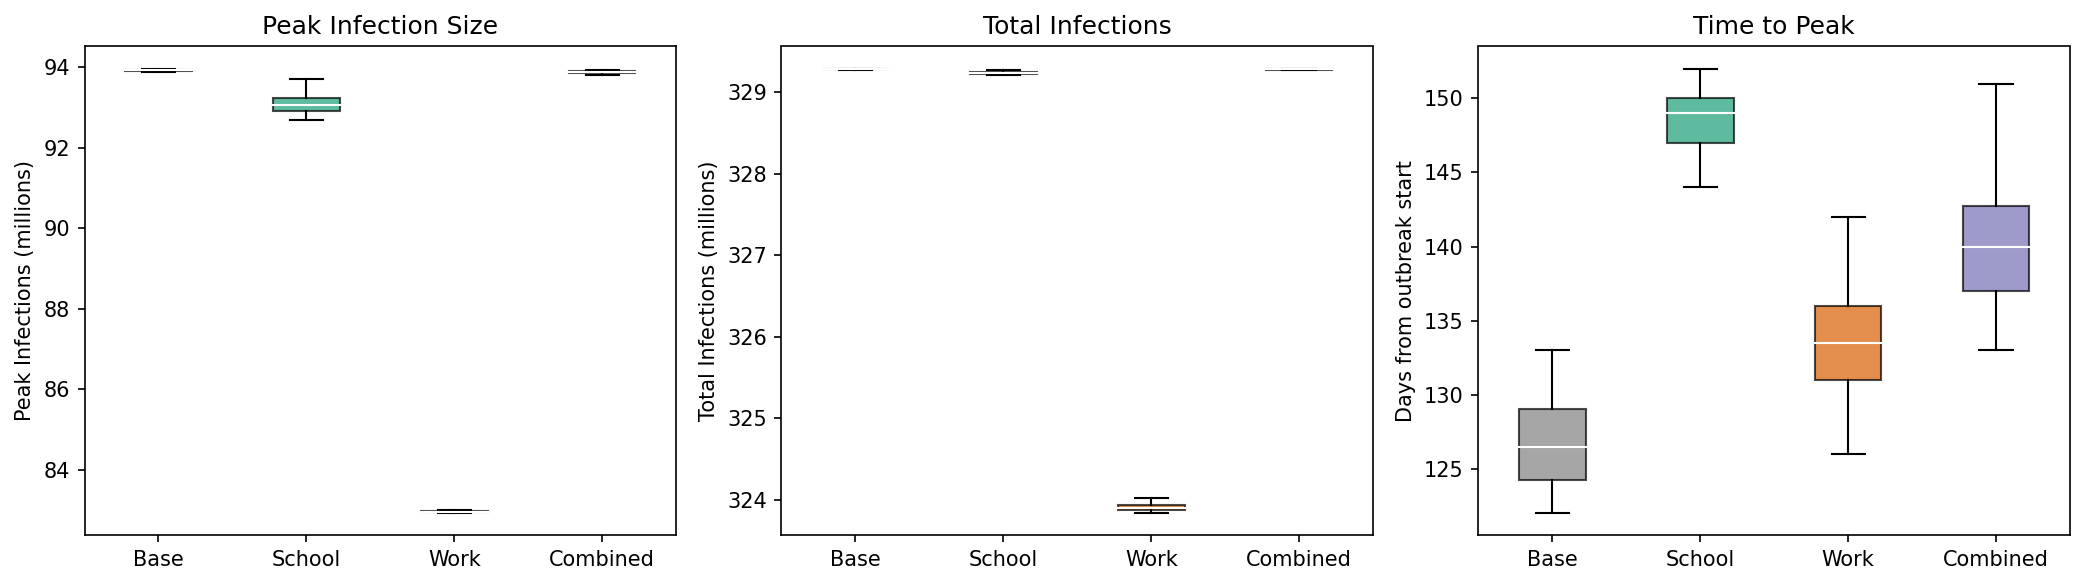

In [25]:
# Boxplot comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=150)

scenario_names = list(metrics.keys())
scenario_colors = ["gray", colors[0], colors[1], colors[2]]

# Peak infections
peak_data = [metrics[s]["peak"]/1e6 for s in scenario_names]
bp1 = axes[0].boxplot(peak_data, patch_artist=True, labels=["Base", "School", "Work", "Combined"],
                      medianprops=dict(color="white"), showfliers=False)
for patch, color in zip(bp1['boxes'], scenario_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_ylabel("Peak Infections (millions)")
axes[0].set_title("Peak Infection Size")

# Total infections
total_data = [metrics[s]["total"]/1e6 for s in scenario_names]
bp2 = axes[1].boxplot(total_data, patch_artist=True, labels=["Base", "School", "Work", "Combined"],
                      medianprops=dict(color="white"), showfliers=False)
for patch, color in zip(bp2['boxes'], scenario_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel("Total Infections (millions)")
axes[1].set_title("Total Infections")

# Time to peak
time_data = [metrics[s]["time_to_peak"] for s in scenario_names]
bp3 = axes[2].boxplot(time_data, patch_artist=True, labels=["Base", "School", "Work", "Combined"],
                      medianprops=dict(color="white"), showfliers=False)
for patch, color in zip(bp3['boxes'], scenario_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[2].set_ylabel("Days from outbreak start")
axes[2].set_title("Time to Peak")

plt.tight_layout()

## Discussion

**Which strategy is most effective?**

Based on the results:

1. **Work-from-home (60%, Apr-Aug)** typically shows the best performance because:
   - Working adults (20-64) have the highest contact rates and comprise the largest population segment
   - The longer duration (5 months) provides sustained protection

2. **School closure (80%, Apr-Jun)** is intense but shorter:
   - Very effective at reducing school-age transmission
   - Limited impact on adult-to-adult transmission
   - Shorter duration means the epidemic may rebound after lifting

3. **Combined lighter (40%, Apr-May)** represents a compromise:
   - Affects multiple transmission routes simultaneously
   - Lower intensity may be more sustainable
   - Shortest duration limits overall impact

**Key trade-offs:**

| Factor | School Closure | Work-from-Home | Combined Lighter |
|--------|---------------|----------------|------------------|
| Economic impact | Lower | Higher | Moderate |
| Social impact | Childcare burden | Varies by sector | Balanced |
| Sustainability | Short-term only | More sustainable | Most sustainable |
| Effectiveness | Age-targeted | Broad | Moderate |

**Real-world considerations:**
- Compliance tends to decrease over time, favoring shorter interventions
- Economic costs of work restrictions can be substantial
- School closures shift childcare burden to parents, affecting work productivity anyway
- The "best" strategy depends on the specific context and policy goals